### 1. https://blog.jovian.ai/human-face-generation-using-gan-2bb4db892e5d
### 2. https://www.theaidream.com/post/generate-realistic-human-face-using-gan-1 

In [23]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Colab library to upload files to notebook
from google.colab import files

# Upload kaggle API key file
uploaded = files.upload()

uploaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhargava39","key":"792800f7231d863e38033cb58f8042d8"}'}

In [4]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle -v

Kaggle API 1.5.12


In [10]:
! mkdir input
! mkdir input/flickrfaceshq-dataset-ffhq

In [11]:
FOLDER_DIR = '/content/input'
DATA_DIR = '/content/input/flickrfaceshq-dataset-ffhq'

In [12]:
! kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

100% 19.5G/19.5G [04:29<00:00, 114MB/s] 
100% 19.5G/19.5G [04:29<00:00, 77.5MB/s]


In [13]:
! unzip flickrfaceshq-dataset-ffhq.zip -d /content/input/flickrfaceshq-dataset-ffhq

! rm flickrfaceshq-dataset-ffhq.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49001.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49002.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49003.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49004.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49005.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49006.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49007.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49008.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49009.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49010.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49011.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49012.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49013.png  
  inflating: /content/input/flickrfaceshq-dataset-ffhq/49014.png  
  inflating

In [15]:
import os, shutil

print(os.listdir(DATA_DIR)[:10])

['01694.png', '27694.png', '31251.png', '16160.png', '16678.png', '43649.png', '34622.png', '37651.png', '24785.png', '45877.png']


In [16]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [82]:
image_size = 64
stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)

In [83]:
dataset = ImageFolder(FOLDER_DIR, transform = T.Compose([T.Resize(image_size), 
                                                         T.CenterCrop(image_size), 
                                                         T.ToTensor(), 
                                                         T.Normalize(*stats)]))

In [19]:
from torch.utils.data import DataLoader

In [20]:
batch_size = 128

In [84]:
train_dl = DataLoader(dataset, batch_size, shuffle = True, pin_memory = True, num_workers = 3)

In [25]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline

In [85]:
def denorm(image_tensors):
    
    return image_tensors * stats[0][1] + stats[0][0]

In [86]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images)
        break

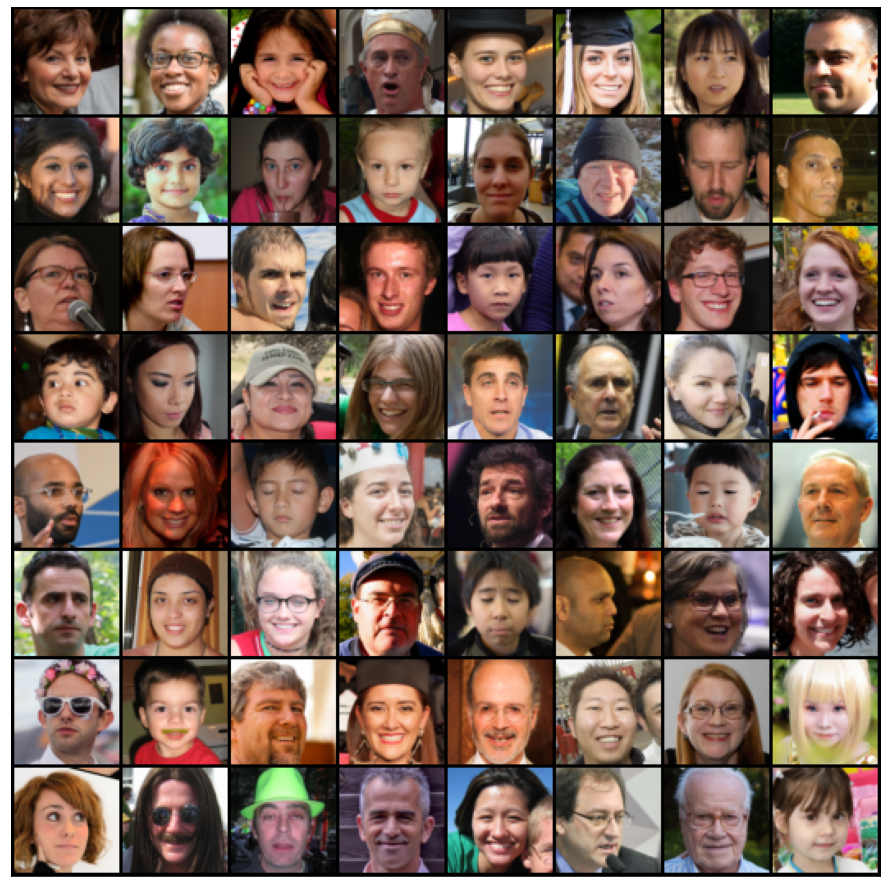

In [30]:
show_batch(train_dl)

In [38]:
def get_default_device():
  if torch.cuda.is_available:
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [78]:
def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(each, device) for each in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        
        return len(self.dl)      

In [87]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)

In [40]:
import torch.nn as nn

In [88]:
discriminator = nn.Sequential(

    # initial dim : 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    
    # dim : 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    
    # dim : 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    
    # dim : 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    
    # dim : 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    # dim : 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
    
)

In [89]:
discriminator = to_device(discriminator, device)

In [90]:
latent_size = 128

In [75]:
generator = nn.Sequential(

    # initial dim : latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    # dim : 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # dim : 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    # dim : 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    # dim : 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    
)

torch.Size([128, 3, 16, 16])


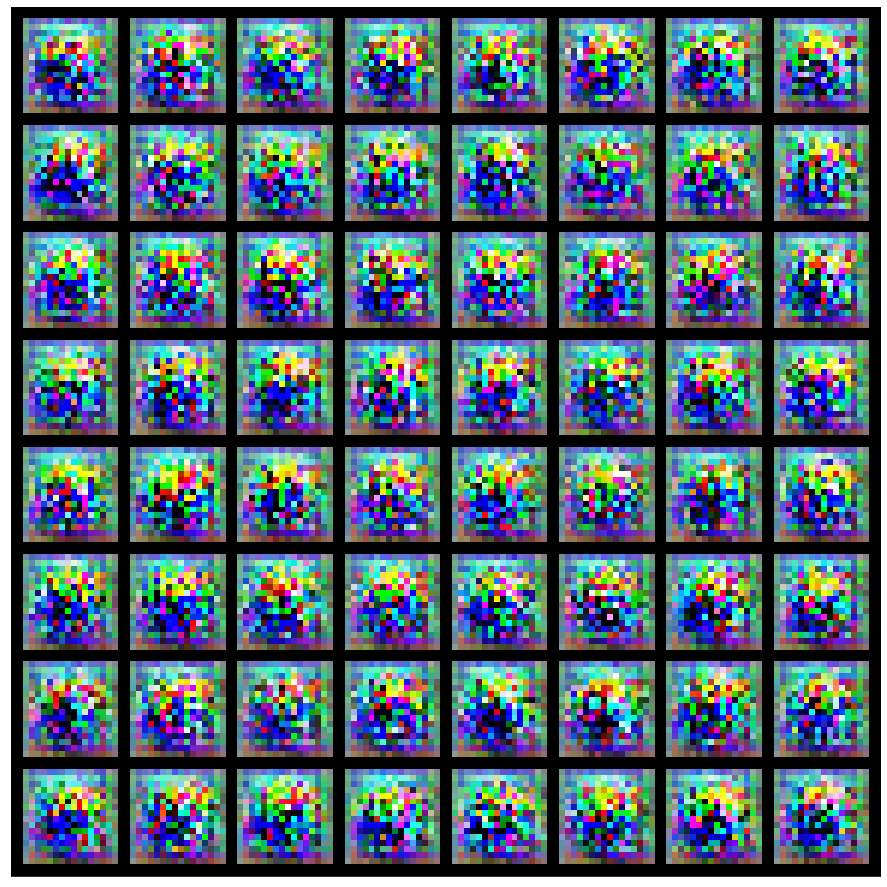

In [48]:
xb = torch.randn(batch_size, latent_size, 1, 1)

fake_images = generator(xb)

print(fake_images.shape)

show_images(fake_images)

In [91]:
generator = to_device(generator, device)

In [50]:
import torch.nn.functional as F

In [92]:
def train_discriminator(real_images, opt_d):
    
    opt_d.zero_grad()
    
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [93]:
def train_generator(opt_g):
    
    opt_g.zero_grad()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(fake_preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [60]:
from torchvision.utils import save_image

In [54]:
sample_dir = 'generated'

os.makedirs(sample_dir, exist_ok = True)

In [71]:
def save_samples(index, latent_tensors, show = True):
    
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [72]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


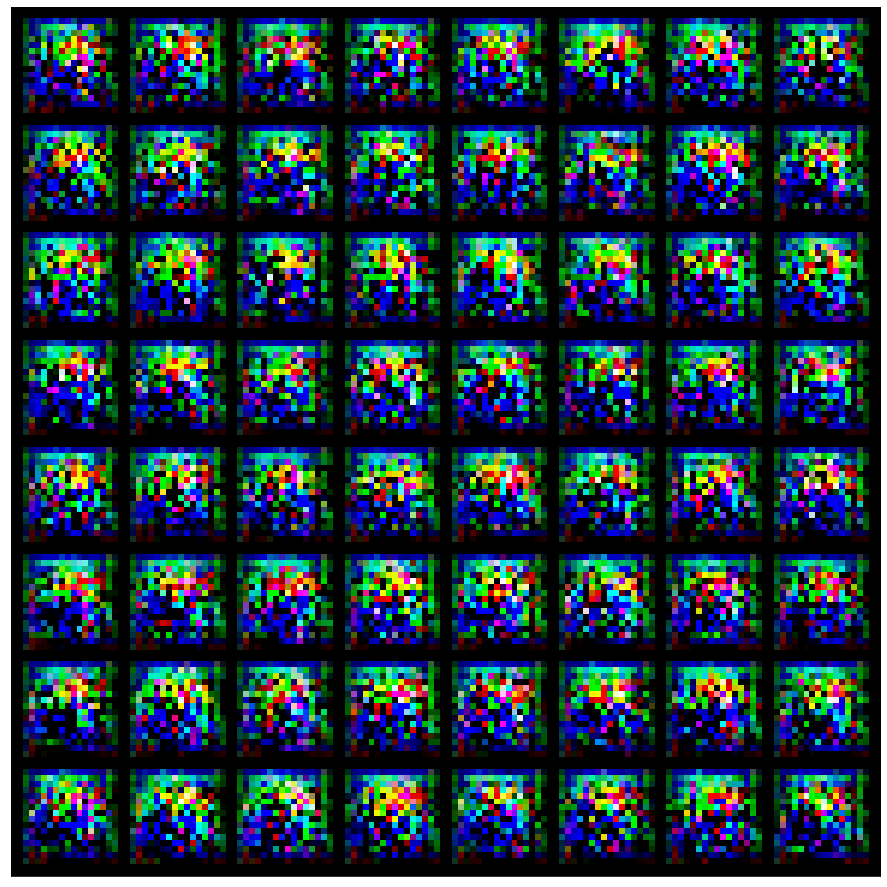

In [61]:
save_samples(0, fixed_latent)

In [62]:
from tqdm.notebook import tqdm

In [73]:
def fit(epochs, lr, start_idx = 1):
    
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    
    for epoch in range(epochs):
        
        for real_images,_ in tqdm(train_dl):
            
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [97]:
lr = 0.0002
epochs = 5 # 25

In [107]:
%%time

history = fit(epochs, lr)

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 3.9408, loss_d: 0.1680, real_score: 0.9050, fake_score: 0.0604
Saving generated-images-0001.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 2.1071, loss_d: 0.9554, real_score: 0.4879, fake_score: 0.0211
Saving generated-images-0002.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 0.1817, loss_d: 3.1028, real_score: 0.0799, fake_score: 0.0015
Saving generated-images-0003.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 2.0553, loss_d: 0.3296, real_score: 0.7531, fake_score: 0.0231
Saving generated-images-0004.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 2.3157, loss_d: 1.1643, real_score: 0.4009, fake_score: 0.0124
Saving generated-images-0005.png
CPU times: user 11min 56s, sys: 15.5 s, total: 12min 11s
Wall time: 53min 50s


In [108]:
losses_g, losses_d, real_scores, fake_scores = history

Text(0.5, 1.0, 'Losses')

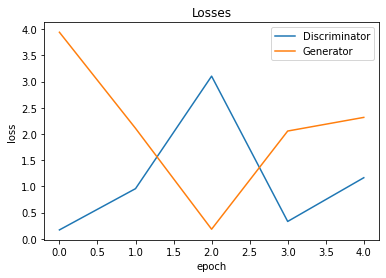

In [109]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

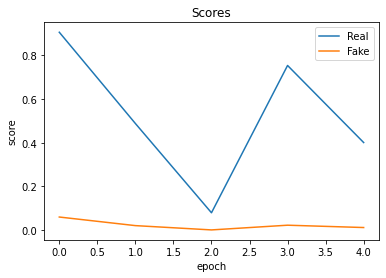

In [110]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

In [111]:
from IPython.display import Image

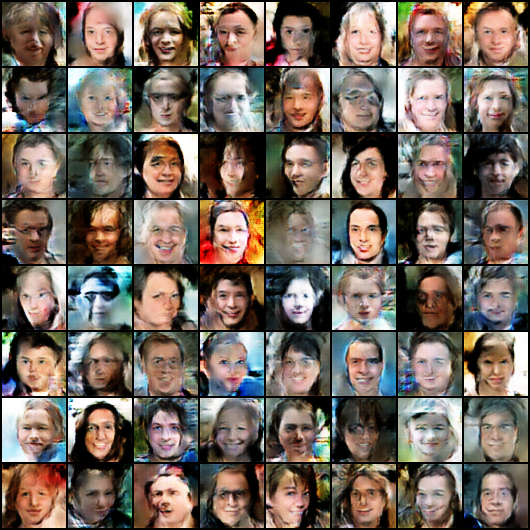

In [112]:
Image('./generated/generated-images-0001.png')

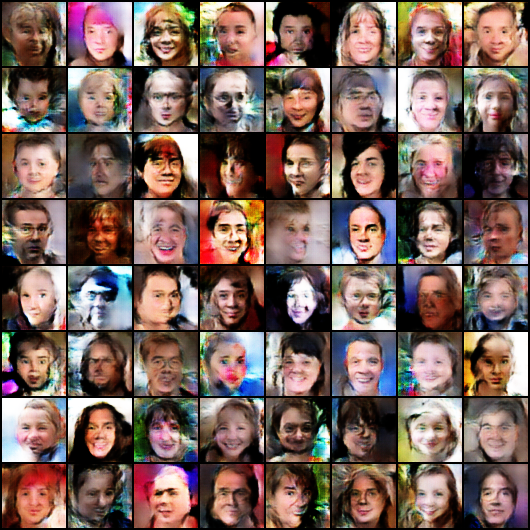

In [113]:
Image('./generated/generated-images-0002.png')

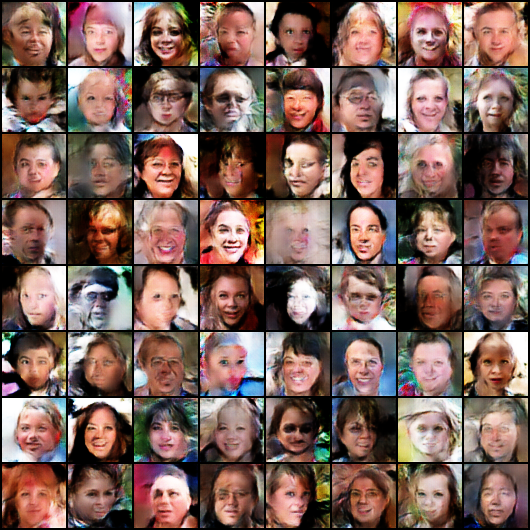

In [114]:
Image('./generated/generated-images-0003.png')

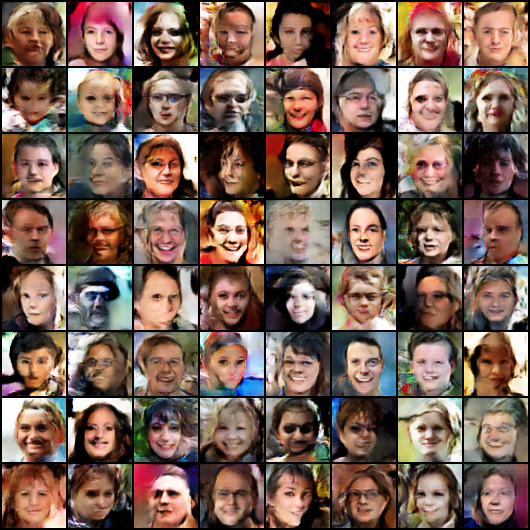

In [115]:
Image('./generated/generated-images-0004.png')

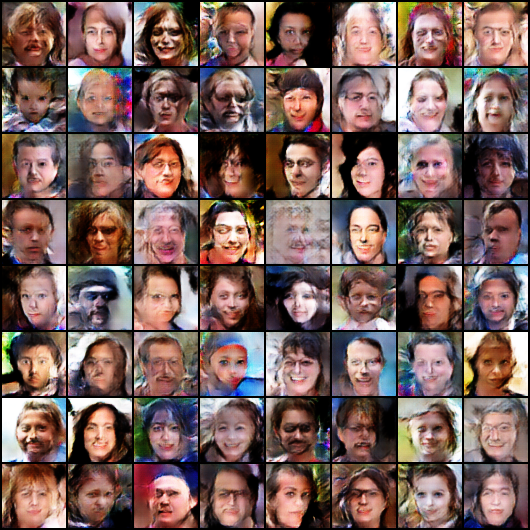

In [116]:
Image('./generated/generated-images-0005.png')

In [106]:
import cv2
import os

vid_fname = 'human_face_generator.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]

out.release()

In [117]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')